In [17]:
%matplotlib inline
import numpy as np
# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 14
from matplotlib.ticker import ScalarFormatter

#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc

rc('text', usetex=True)

# import seaborn as sns
from scipy.stats import norm
import json
from sklearn.metrics import mean_squared_error
from math import sqrt
# sns.set()
# sns.set_style("ticks")
# sns.set_style("white")
# sns.set_context("talk")
# New pallete: Red/Blue/Black
gang_rgb = (255,64,39,255)
exhu_rgb = (0,173,255,255)
tred_rgb = (46,46,58,255)
xy_rgb = (187,184,178,255)

gang_col = [float(i) / 255.0 for i in gang_rgb]
exhu_col = [float(i) / 255.0 for i in exhu_rgb]
tred_col = [float(i) / 255.0 for i in tred_rgb]
xy_col = [float(i) / 255.0 for i in xy_rgb]

In [12]:
def process_result_obj(d, tool_dict):
    if not d:
        return
    else:
        tool_dict['X'].append(d['tr'])
        tool_dict['Y'].append(d['gt'])
        tool_dict['Y_pos'].append(d['ci'][1] - d['gt'])
        tool_dict['Y_neg'].append(d['gt'] - d['ci'][0])
    return

def max_arrays (tool_dict):
    return max(tool_dict['X'] + \
                tool_dict['Y'] + \
                tool_dict['Y_pos'])
def max_tools (locus_dict):
    return max([max_arrays(locus_dict['gang']),\
                max_arrays(locus_dict['tred']),\
                max_arrays(locus_dict['exhu'])])

# Section 1

## Read Probabilities

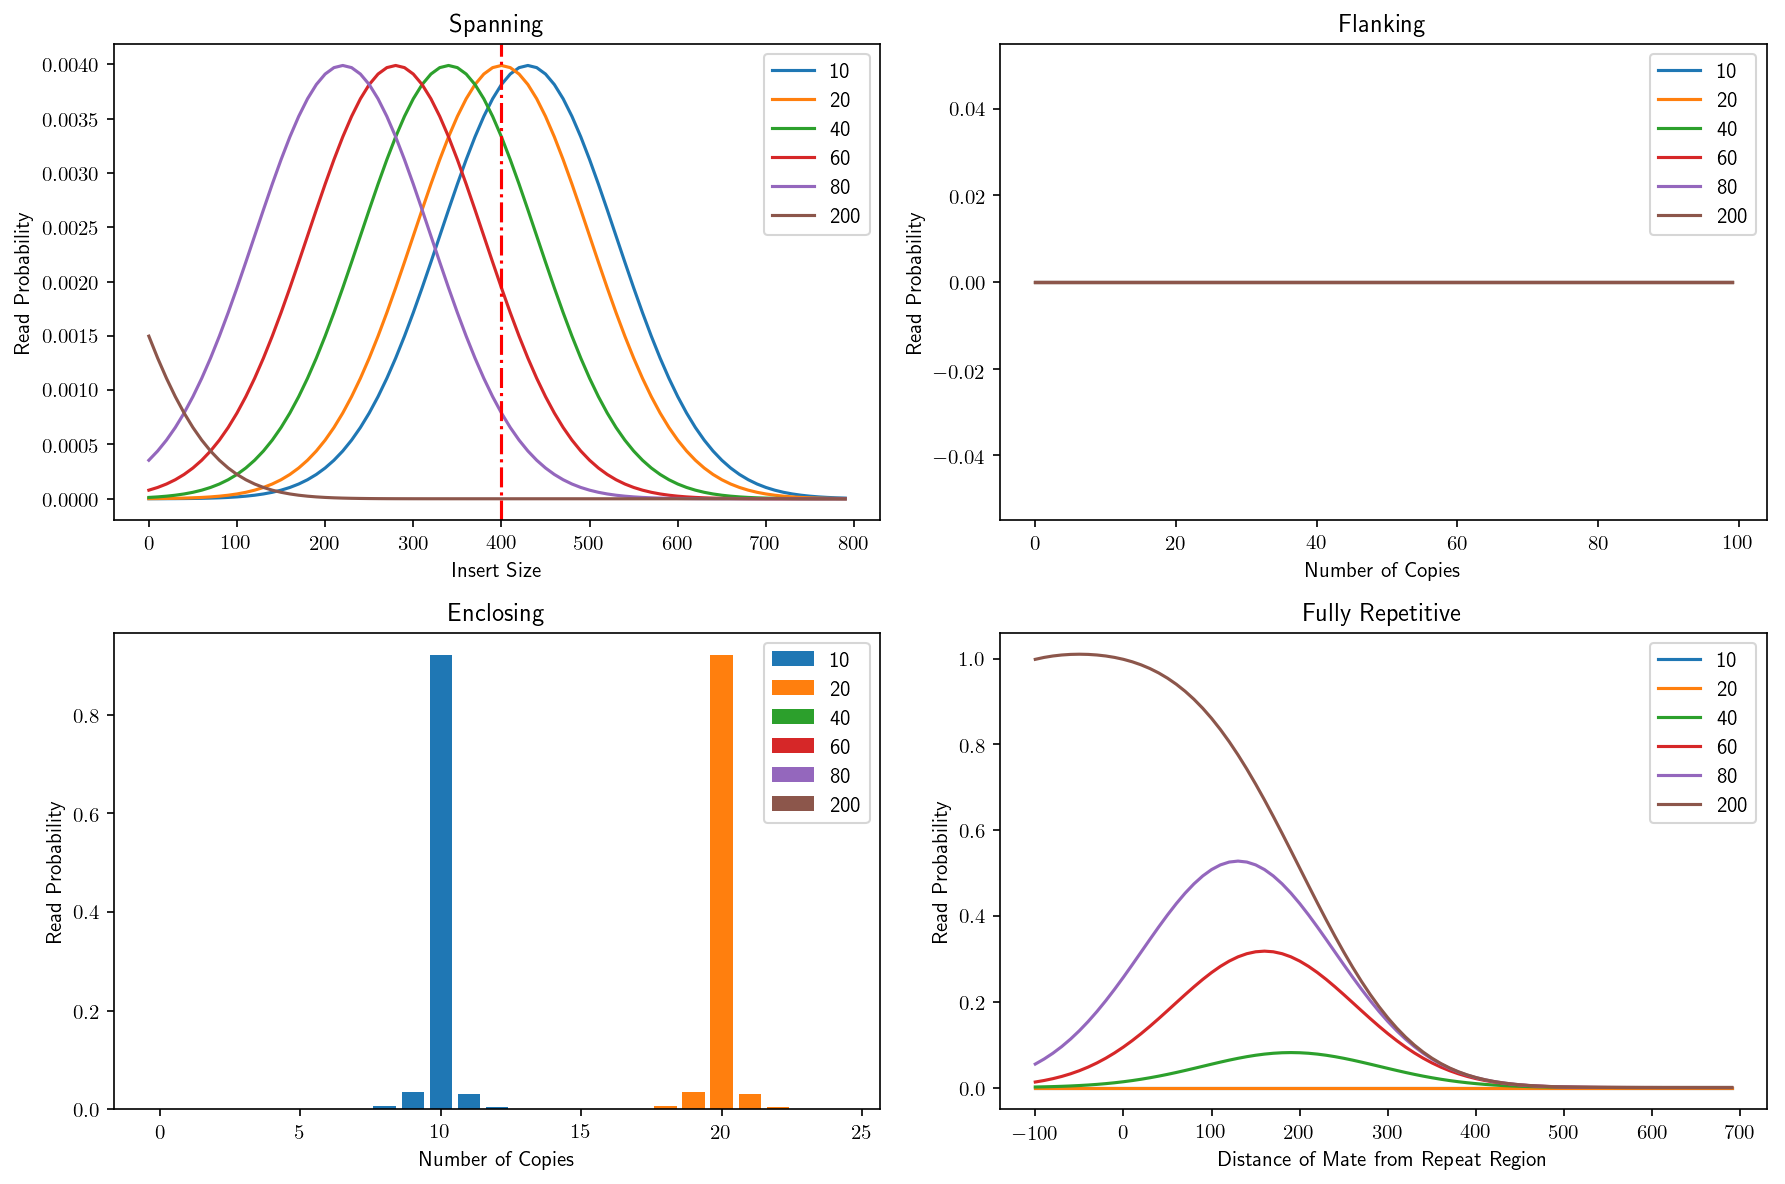

In [4]:
def span_read_prob(data_list, allele, ref, motif_len, mean, std):
    return norm.pdf(data_list, loc = mean - (allele - ref) * motif_len, scale = std)
def flank_read_prob(data_list, allele):
    ret_list = []
    for data in data_list:
        if data > allele or data < 0:
            ret_list.append(0)
        else:
            ret_list.append(1 / allele)
    return ret_list
def encl_read_prob(data_list, allele, stutter_p, stutter_up, stutter_down):
    ret_list = []
    for data in data_list:
        delta = float(data - allele)
        if delta == 0.0:
            prob = 1.0 - stutter_up - stutter_down
        elif delta > 0.0:
            prob = stutter_p * stutter_up * (1.0 - stutter_p) ** (delta - 1.0)
        else:
            prob = stutter_p * stutter_down * (1.0 - stutter_p) ** (-delta - 1.0)
        ret_list.append(prob)
    return ret_list
def frr_read_prob(data_list, allele, flank_len, motif_len, read_len, mean, std):
    str_len = allele * motif_len
    ret_list = []
    for data in data_list:
        if (str_len < read_len):
            prob = 0
        else:
            norm_const = norm.cdf(2 * flank_len + str_len, mean, std) -\
                            norm.cdf(2 * read_len, mean, std)
            term1 = norm.cdf(read_len + data + str_len, mean, std) - \
                            norm.cdf(2 * read_len + data, mean, std)
            prob = 1 / norm_const * term1
        ret_list.append(prob)
    return ret_list
        
flank_len = 6000
mean = 400
std = 100
motif_len = 3
ref = 20
read_len = 100
allele_list = [10, 20, 40, 60, 80,200]

fig_rp = plt.figure(num=1,figsize=(12,8), dpi = 150)
ax_rp_span = fig_rp.add_subplot(221)

span_data_list = range(0,800,10)
for allele in allele_list:
    span_rp = span_read_prob(span_data_list, allele, ref, motif_len, mean, std)
    ax_rp_span.plot(span_data_list, span_rp, label=str(allele))
ax_rp_span.axvline(mean, color='r', linestyle='-.')
plt.title('Spanning'); plt.legend()
ax_rp_span.set_xlabel('Insert Size'); ax_rp_span.set_ylabel('Read Probability')

ax_rp_flank = fig_rp.add_subplot(222)
flank_data_list = range(0,100,1)
for allele in allele_list:
    flank_rp = flank_read_prob(flank_data_list, allele)
    ax_rp_flank.plot(flank_data_list, flank_rp, label=str(allele))
plt.title('Flanking'); plt.legend()
ax_rp_flank.set_xlabel('Number of Copies'); ax_rp_flank.set_ylabel('Read Probability')

stutter_p = 0.8189
stutter_up = 0.0365
stutter_down = 0.0428
ax_rp_encl = fig_rp.add_subplot(223)
encl_data_list = range(0,25,1)
for allele in allele_list:
    encl_rp = encl_read_prob(encl_data_list, allele, stutter_p, stutter_up, stutter_down)
    ax_rp_encl.bar(encl_data_list, encl_rp, label=str(allele))
plt.title('Enclosing'); plt.legend()
ax_rp_encl.set_xlabel('Number of Copies'); ax_rp_encl.set_ylabel('Read Probability')



ax_rp_frr = fig_rp.add_subplot(224)
frr_data_list = range(-read_len,700,10)
for allele in allele_list:
    frr_rp = frr_read_prob(frr_data_list, allele, flank_len, motif_len, read_len, mean, std)
    ax_rp_frr.plot(frr_data_list, frr_rp, label=str(allele))
plt.title('Fully Repetitive'); plt.legend()
ax_rp_frr.set_xlabel('Distance of Mate from Repeat Region'); ax_rp_frr.set_ylabel('Read Probability')

plt.tight_layout()
plt.savefig('Supp1_ReadProb.pdf')

## Class Probabilities

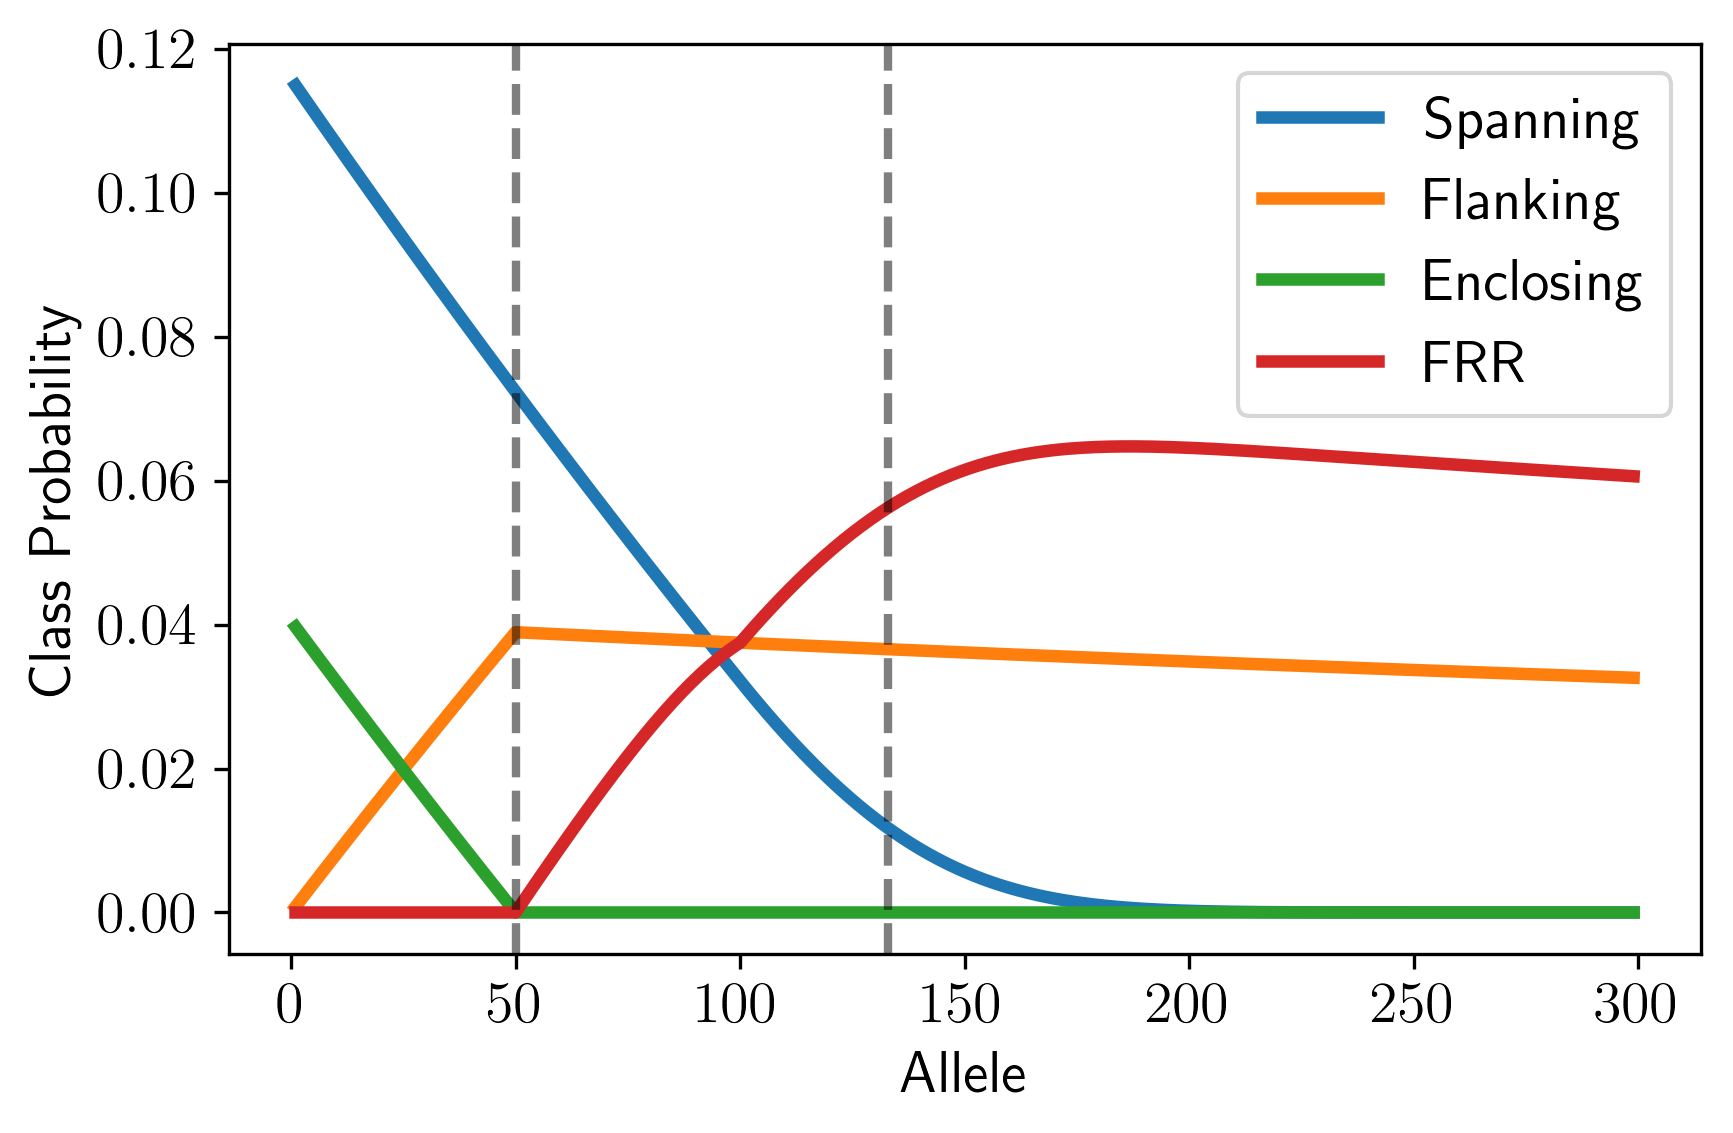

In [18]:
def span_class_prob(allele_list, flank_len, motif_len, read_len, mean, std):
    ret_list = []
    for allele in allele_list:
        str_len = allele * motif_len
        norm_const = norm.cdf(2 * flank_len + str_len, mean, std) -\
                            norm.cdf(2 * read_len, mean, std);
        coef0 = 1.0 / norm_const / float(2 * flank_len + str_len - 2 * read_len);
        coef1 = float(mean - str_len)
        coef2 = - float(std ** 2)
        
        if (2 * read_len >= str_len):
            term1 = norm.cdf(2 * flank_len + str_len, mean, std) -\
                            norm.cdf(2 * read_len, mean, std)
            term2 = norm.pdf(2 * flank_len + str_len, mean, std) -\
                            norm.pdf(2 * read_len, mean, std)
        else:
            term1 = norm.cdf(2 * flank_len + str_len, mean, std) -\
                            norm.cdf(str_len, mean, std)
            term2 = norm.pdf(2 * flank_len + str_len, mean, std) -\
                            norm.pdf(str_len, mean, std)
        prob = coef0 * (coef1 * term1 + coef2 * term2)
        ret_list.append(prob)
    return ret_list
def flank_class_prob(allele_list, flank_len, motif_len, read_len):
    ret_list = []
    for allele in allele_list:
        str_len = allele * motif_len
        if str_len > read_len:
            prob = float(read_len) / float(2 * flank_len + str_len - 2 * read_len)
        else:
            prob = float(str_len) / float(2 * flank_len + str_len - 2 * read_len)
        ret_list.append(prob)
    return ret_list
def encl_class_prob(allele_list, flank_len, motif_len, read_len):
    ret_list = []
    for allele in allele_list:
        str_len = allele * motif_len
        if read_len <= str_len:
            prob = 0
        else:
            prob = float(read_len - str_len) / float(2 * flank_len + str_len - 2 * read_len)
        ret_list.append(prob)
    return ret_list
def frr_class_prob(allele_list, flank_len, motif_len, read_len, mean, std):
    ret_list = []
    for allele in allele_list:
        str_len = allele * motif_len
        if (str_len < read_len):
            prob = 0
        else:
            norm_const = 1.0 - norm.cdf(2 * read_len, mean, std)
            coef0 = 1.0 / norm_const / (2.0 * flank_len + str_len - 2.0 * read_len)
            coef1 = - std ** 2
            term1 = norm.pdf(str_len, mean, std) - \
                            norm.pdf(2 * read_len, mean, std)
            coef2 = mean - read_len
            term2 = norm.cdf(str_len, mean, std) - \
                            norm.cdf(2 * read_len, mean, std)
            coef3 = str_len - read_len;
            term3 = norm.cdf(2 * flank_len + str_len, mean, std) - \
                                        norm.cdf(str_len, mean, std);
            if str_len >= 2 * read_len:
                prob = coef0 * (coef1 * term1 + coef2 * term2 + coef3 * term3)
            else:
                prob = coef0 * coef3 * term3;
        ret_list.append(prob)
    return ret_list
        
flank_len = 2000
mean = 400
std = 100
motif_len = 3
ref = 20
allele_list = [10, 20, 40, 60, 80,200]

fig_rp = plt.figure(num=1,figsize=(6,4), dpi = 300)


read_len = 150

ax_cp = fig_rp.add_subplot(111)
allele_list = range(1,300,1)
span_cp = span_class_prob(allele_list, flank_len, motif_len, read_len, mean, std)
flank_cp = flank_class_prob(allele_list, flank_len, motif_len, read_len)
encl_cp = encl_class_prob(allele_list, flank_len, motif_len, read_len)
frr_cp = frr_class_prob(allele_list, flank_len, motif_len, read_len, mean, std)
ax_cp.plot(allele_list, span_cp, lw=3, label='Spanning')
ax_cp.plot(allele_list, flank_cp, lw=3, label='Flanking')
ax_cp.plot(allele_list, encl_cp, lw=3, label='Enclosing')
ax_cp.plot(allele_list, frr_cp, lw=3, label='FRR')

plt.legend()
ax_cp.set_xlabel('Allele'); ax_cp.set_ylabel('Class Probability')
ax_cp.axvline(x=read_len / 3, linewidth = 2, linestyle = '--', color = 'k', alpha = 0.5)
ax_cp.axvline(x=mean / 3, linewidth = 2, linestyle = '--', color = 'k', alpha = 0.5)
plt.tight_layout()
plt.savefig('Supp2_ClassProb.pdf')

[u'200', u'600', u'300', u'700', u'400', u'800', u'500']
>>Simulation Plot information extracted.
200 | Red: GangSTR r=67.4107 | Blue: ExpansionHunter r=54.5193 | Black: TREDPARSE r=378.1579
300 | Red: GangSTR r=37.5225 | Blue: ExpansionHunter r=51.6344 | Black: TREDPARSE r=389.5366
400 | Red: GangSTR r=43.8380 | Blue: ExpansionHunter r=57.7621 | Black: TREDPARSE r=387.7835
500 | Red: GangSTR r=39.6286 | Blue: ExpansionHunter r=52.0725 | Black: TREDPARSE r=386.0074
600 | Red: GangSTR r=37.9046 | Blue: ExpansionHunter r=57.9128 | Black: TREDPARSE r=385.6771
700 | Red: GangSTR r=40.7695 | Blue: ExpansionHunter r=58.2389 | Black: TREDPARSE r=373.2494
800 | Red: GangSTR r=47.1128 | Blue: ExpansionHunter r=67.0583 | Black: TREDPARSE r=378.7217


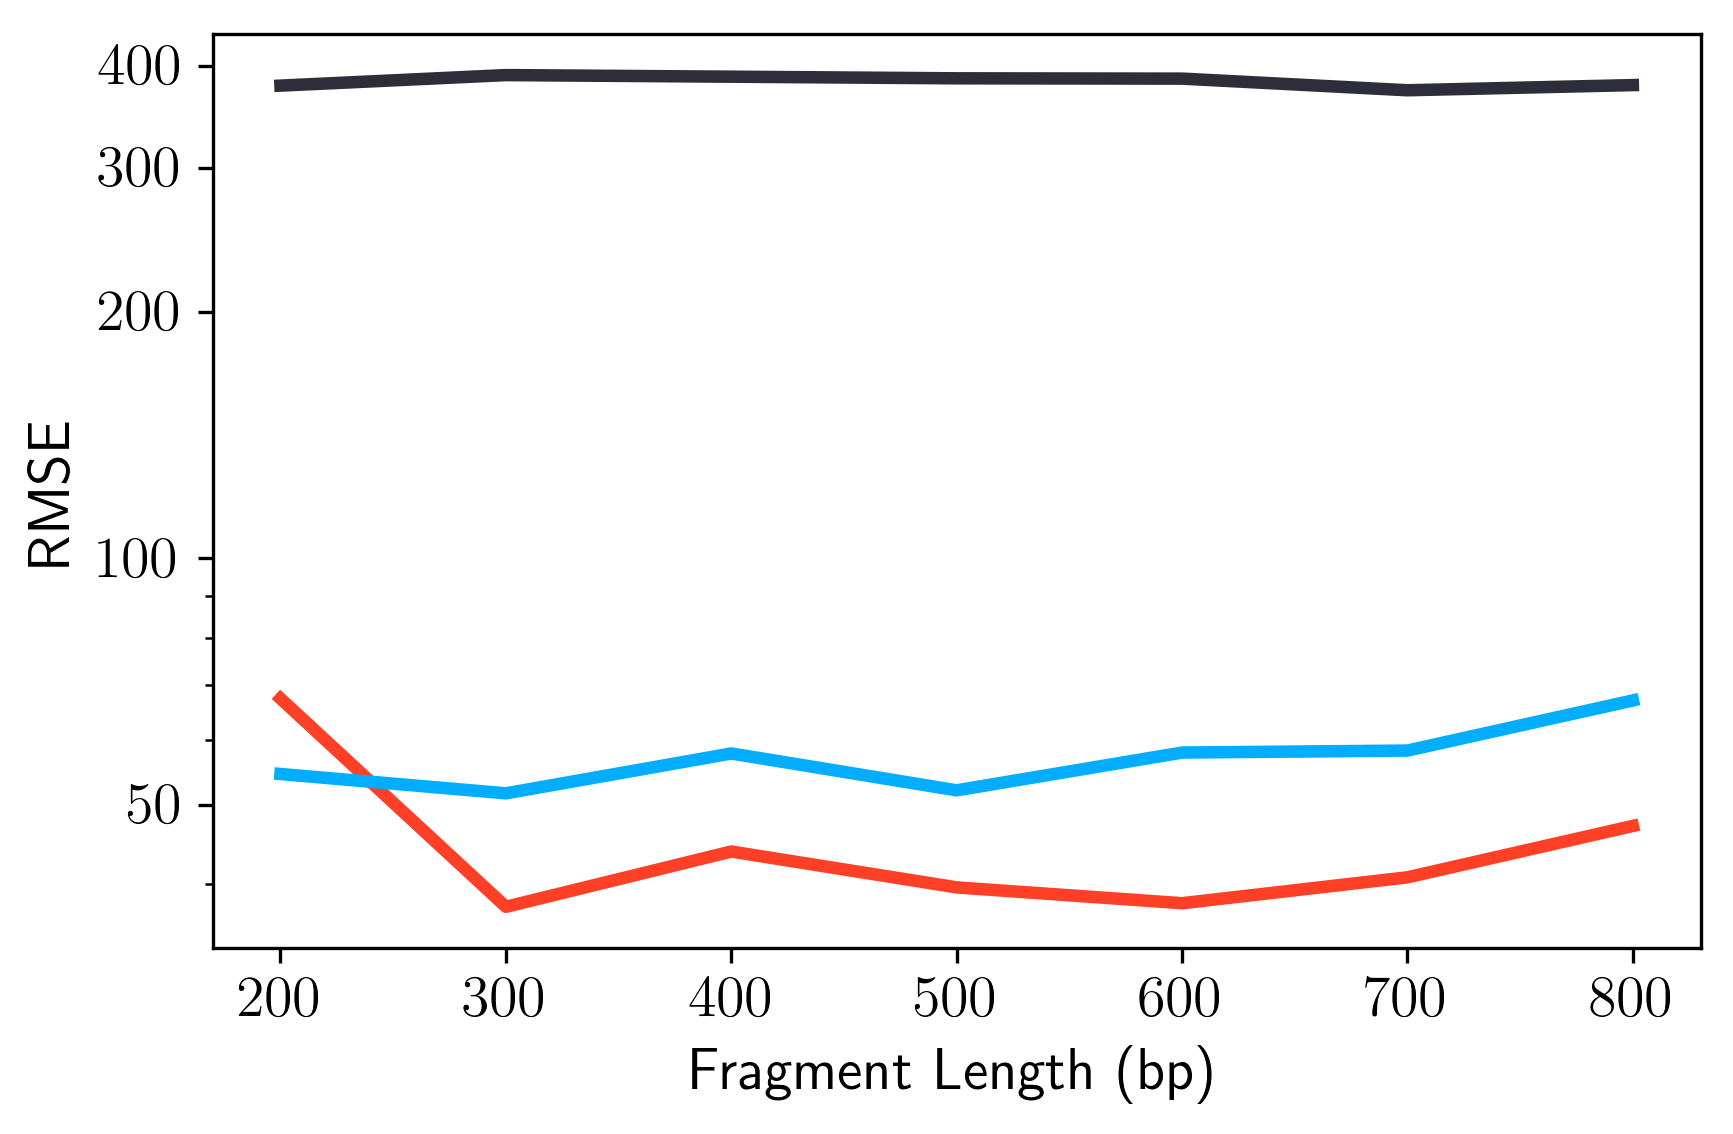

In [19]:
plot_flag = {'gang': 1,
             'tred': 1,
             'exhu': 1}

SIM_DATAPATH = '../new_sim/plot/'

res_file_name = 'HTT_13_var_dist'
sim_result = json.load(open(SIM_DATAPATH + res_file_name + '.json'))
print(sim_result.keys())

variable = [str(i) for i in sorted([int(i) for i in sim_result.keys()])]


sim_plots = {}
for d in variable:
#     experiment = sim_prefix + d
#     locus = '_'.join(experiment.split('_')[0:2])
    sim_plots[d] = {'gang':{'X':[],'Y':[],'Y_pos':[],'Y_neg':[]},\
                       'tred':{'X':[],'Y':[],'Y_pos':[],'Y_neg':[]},\
                       'exhu':{'X':[],'Y':[],'Y_pos':[],'Y_neg':[]}}
#     exp_path = SIM_DATAPATH + experiment + '.json'
#     exp_res = json.load(open(exp_path))
    for sample in sim_result[d]:
        process_result_obj(sim_result[d][sample]['gang']['0'], sim_plots[d]['gang'])
        process_result_obj(sim_result[d][sample]['gang']['1'], sim_plots[d]['gang'])
        process_result_obj(sim_result[d][sample]['tred']['0'], sim_plots[d]['tred'])
        process_result_obj(sim_result[d][sample]['tred']['1'], sim_plots[d]['tred'])
        process_result_obj(sim_result[d][sample]['exhu']['0'], sim_plots[d]['exhu'])
        process_result_obj(sim_result[d][sample]['exhu']['1'], sim_plots[d]['exhu'])
print ('>>Simulation Plot information extracted.')

r_d = {'gang':[], 'tred':[], 'exhu':[]}
for d in variable:
    gang_dict = sim_plots[d]['gang']
    tred_dict = sim_plots[d]['tred']
    exhu_dict = sim_plots[d]['exhu']
    
    max_genot = 500
#     fig = plt.figure(num=d,figsize=(6,4), dpi = 150)
#     ax = fig.add_subplot(1,1,1)
    if plot_flag['gang'] == 1:
        #ax.errorbar(gang_dict['X'], gang_dict['Y'],\
        #            yerr = [gang_dict['Y_neg'], gang_dict['Y_pos']],\
        #            fmt='o', color = 'r', alpha = 0.35, label = 'GangSTR')
        r_gang = format(sqrt(mean_squared_error(gang_dict['X'],gang_dict['Y'])), '.4f')
        r_d['gang'].append(r_gang)
    else:
        r_gang = str(-1)
    if plot_flag['tred'] == 1:
        #ax.errorbar(tred_dict['X'], tred_dict['Y'],\
        #        yerr = [tred_dict['Y_neg'], tred_dict['Y_pos']],\
        #        fmt='.', color = 'g', alpha = 0.35, label = 'TredParse')
        r_tred = format(sqrt(mean_squared_error(tred_dict['X'],tred_dict['Y'])), '.4f')
        r_d['tred'].append(r_tred)
    else:
        r_tred = str(-1)
    if plot_flag['exhu'] == 1:
        #ax.errorbar(exhu_dict['X'], exhu_dict['Y'],\
        #            yerr = [exhu_dict['Y_neg'], exhu_dict['Y_pos']],\
        #            fmt='v', color = 'b', alpha = 0.35, label = 'ExpansionHunter')
        r_exhu = format(sqrt(mean_squared_error(exhu_dict['X'],exhu_dict['Y'])), '.4f')
        r_d['exhu'].append(r_exhu)
    else:
        r_exhu = str(-1)

#     ax.plot(range(-20, max_genot), range(-20, max_genot), color = 'g')
#     ax.set_xlabel('True (# Copies)')
#     ax.set_ylabel('Estimate (# Copies)')
#     ax.set_xlim([0,max_genot])
#     ax.set_ylim([0,max_genot])
#     # fig.savefig('/storage/nmmsv/analysis/GangSTR-analyses/simulation/plot/' + experiment + '.pdf')
#     plt.legend()
    
    print ((d + ' | Red: GangSTR r='+r_gang\
                +' | Blue: ExpansionHunter r='+r_exhu\
                +' | Black: TREDPARSE r='+r_tred))
    
fig = plt.figure(num=2,figsize=(6,4), dpi = 300)
ax = fig.add_subplot(1,1,1)
ax.plot([int(i) for i in variable], [float(j) for j in r_d['gang']], color = gang_col, lw = 3)
ax.plot([int(i) for i in variable], [float(j) for j in r_d['tred']], color = tred_col, lw = 3)
ax.plot([int(i) for i in variable], [float(j) for j in r_d['exhu']], color = exhu_col, lw = 3)
ax.set_ylabel('RMSE'); ax.set_xlabel('Fragment Length (bp)')
ax.set_yscale('log')
ax.set_yticks([50, 100, 200, 300, 400])
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
plt.tight_layout()
plt.savefig('Supp3_VariableFragmentLength.pdf')


[u'200', u'150', u'300', u'50', u'100', u'250']
>>Simulation Plot information extracted.
50 | Red: GangSTR r=169.2871 | Blue: ExpansionHunter r=172.3398 | Green: TREDPARSE r=334.0108
100 | Red: GangSTR r=46.0365 | Blue: ExpansionHunter r=138.6650 | Green: TREDPARSE r=397.0524
150 | Red: GangSTR r=34.9427 | Blue: ExpansionHunter r=52.1227 | Green: TREDPARSE r=385.5234
200 | Red: GangSTR r=36.1439 | Blue: ExpansionHunter r=63.0206 | Green: TREDPARSE r=374.0799
250 | Red: GangSTR r=51.4750 | Blue: ExpansionHunter r=60.3069 | Green: TREDPARSE r=367.9017
300 | Red: GangSTR r=51.9037 | Blue: ExpansionHunter r=51.9037 | Green: TREDPARSE r=365.6554


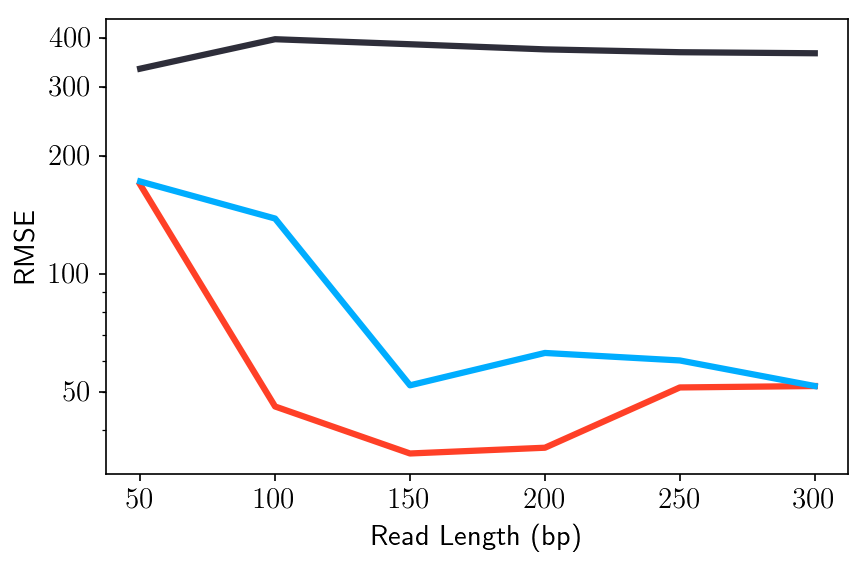

In [20]:
plot_flag = {'gang': 1,
             'tred': 1,
             'exhu': 1}

SIM_DATAPATH = '../new_sim/plot/'

res_file_name = 'HTT_3_var_readlen'
sim_result = json.load(open(SIM_DATAPATH + res_file_name + '.json'))
print(sim_result.keys())

variable = [str(i) for i in sorted([int(i) for i in sim_result.keys()])]


sim_plots = {}
for d in variable:
#     experiment = sim_prefix + d
#     locus = '_'.join(experiment.split('_')[0:2])
    sim_plots[d] = {'gang':{'X':[],'Y':[],'Y_pos':[],'Y_neg':[]},\
                       'tred':{'X':[],'Y':[],'Y_pos':[],'Y_neg':[]},\
                       'exhu':{'X':[],'Y':[],'Y_pos':[],'Y_neg':[]}}
#     exp_path = SIM_DATAPATH + experiment + '.json'
#     exp_res = json.load(open(exp_path))
    for sample in sim_result[d]:
        process_result_obj(sim_result[d][sample]['gang']['0'], sim_plots[d]['gang'])
        process_result_obj(sim_result[d][sample]['gang']['1'], sim_plots[d]['gang'])
        process_result_obj(sim_result[d][sample]['tred']['0'], sim_plots[d]['tred'])
        process_result_obj(sim_result[d][sample]['tred']['1'], sim_plots[d]['tred'])
        process_result_obj(sim_result[d][sample]['exhu']['0'], sim_plots[d]['exhu'])
        process_result_obj(sim_result[d][sample]['exhu']['1'], sim_plots[d]['exhu'])
print ('>>Simulation Plot information extracted.')

r_d = {'gang':[], 'tred':[], 'exhu':[]}
for d in variable:
    gang_dict = sim_plots[d]['gang']
    tred_dict = sim_plots[d]['tred']
    exhu_dict = sim_plots[d]['exhu']
    
    max_genot = 500
#     fig = plt.figure(num=d,figsize=(6,4), dpi = 150)
#     ax = fig.add_subplot(1,1,1)
    if plot_flag['gang'] == 1:
        #ax.errorbar(gang_dict['X'], gang_dict['Y'],\
        #            yerr = [gang_dict['Y_neg'], gang_dict['Y_pos']],\
        #            fmt='o', color = 'r', alpha = 0.35, label = 'GangSTR')
        r_gang = format(sqrt(mean_squared_error(gang_dict['X'],gang_dict['Y'])), '.4f')
        r_d['gang'].append(r_gang)
    else:
        r_gang = str(-1)
    if plot_flag['tred'] == 1:
        #ax.errorbar(tred_dict['X'], tred_dict['Y'],\
        #        yerr = [tred_dict['Y_neg'], tred_dict['Y_pos']],\
        #        fmt='.', color = 'g', alpha = 0.35, label = 'TredParse')
        r_tred = format(sqrt(mean_squared_error(tred_dict['X'],tred_dict['Y'])), '.4f')
        r_d['tred'].append(r_tred)
    else:
        r_tred = str(-1)
    if plot_flag['exhu'] == 1:
        #ax.errorbar(exhu_dict['X'], exhu_dict['Y'],\
        #            yerr = [exhu_dict['Y_neg'], exhu_dict['Y_pos']],\
        #            fmt='v', color = 'b', alpha = 0.35, label = 'ExpansionHunter')
        r_exhu = format(sqrt(mean_squared_error(exhu_dict['X'],exhu_dict['Y'])), '.4f')
        r_d['exhu'].append(r_exhu)
    else:
        r_exhu = str(-1)

#     ax.plot(range(-20, max_genot), range(-20, max_genot), color = 'g')
#     ax.set_xlabel('True (# Copies)')
#     ax.set_ylabel('Estimate (# Copies)')
#     ax.set_xlim([0,max_genot])
#     ax.set_ylim([0,max_genot])
#     # fig.savefig('/storage/nmmsv/analysis/GangSTR-analyses/simulation/plot/' + experiment + '.pdf')
#     plt.legend()
    
    print ((d + ' | Red: GangSTR r='+r_gang\
                +' | Blue: ExpansionHunter r='+r_exhu\
                +' | Green: TREDPARSE r='+r_tred))
    
fig = plt.figure(num=2,figsize=(6,4), dpi = 150)
ax = fig.add_subplot(1,1,1)

ax.plot([int(i) for i in variable], [float(j) for j in r_d['gang']], color = gang_col, lw = 3)
ax.plot([int(i) for i in variable], [float(j) for j in r_d['tred']], color = tred_col, lw = 3)
ax.plot([int(i) for i in variable], [float(j) for j in r_d['exhu']], color = exhu_col, lw = 3)
ax.set_ylabel('RMSE'); ax.set_xlabel('Read Length (bp)')
ax.set_yscale('log')
ax.set_yticks([50, 100, 200, 300, 400])
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
plt.tight_layout()
plt.savefig('Supp3_VariableReadLen.pdf')

In [127]:
# for res in sim_result['300']:
#     print res, sim_result['300'][res]['gang']

[u'10', u'20', u'150', u'30', u'50', u'5', u'70', u'100', u'250']
>>Simulation Plot information extracted.
5 | Red: GangSTR r=94.2112 | Blue: ExpansionHunter r=168.8420 | Green: TREDPARSE r=386.7695
10 | Red: GangSTR r=72.0607 | Blue: ExpansionHunter r=101.6787 | Green: TREDPARSE r=374.9197
20 | Red: GangSTR r=50.1969 | Blue: ExpansionHunter r=72.2397 | Green: TREDPARSE r=385.5513
30 | Red: GangSTR r=36.1246 | Blue: ExpansionHunter r=54.5636 | Green: TREDPARSE r=386.3328
50 | Red: GangSTR r=33.7506 | Blue: ExpansionHunter r=48.3876 | Green: TREDPARSE r=385.9125
70 | Red: GangSTR r=30.9072 | Blue: ExpansionHunter r=49.4136 | Green: TREDPARSE r=385.6155
100 | Red: GangSTR r=24.1855 | Blue: ExpansionHunter r=40.6609 | Green: TREDPARSE r=385.7015
150 | Red: GangSTR r=19.3720 | Blue: ExpansionHunter r=39.8391 | Green: TREDPARSE r=385.8268
250 | Red: GangSTR r=20.7399 | Blue: ExpansionHunter r=41.9774 | Green: TREDPARSE r=386.0757


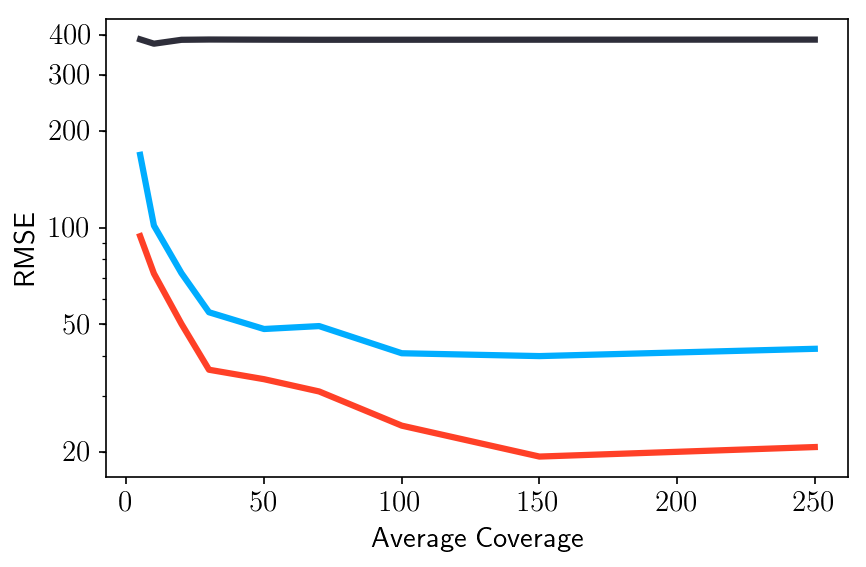

In [21]:
plot_flag = {'gang': 1,
             'tred': 1,
             'exhu': 1}

SIM_DATAPATH = '../new_sim/plot/'

res_file_name = 'HTT_2_var_coverage'
sim_result = json.load(open(SIM_DATAPATH + res_file_name + '.json'))
print(sim_result.keys())

variable = [str(i) for i in sorted([int(i) for i in sim_result.keys()])]


sim_plots = {}
for d in variable:
#     experiment = sim_prefix + d
#     locus = '_'.join(experiment.split('_')[0:2])
    sim_plots[d] = {'gang':{'X':[],'Y':[],'Y_pos':[],'Y_neg':[]},\
                       'tred':{'X':[],'Y':[],'Y_pos':[],'Y_neg':[]},\
                       'exhu':{'X':[],'Y':[],'Y_pos':[],'Y_neg':[]}}
#     exp_path = SIM_DATAPATH + experiment + '.json'
#     exp_res = json.load(open(exp_path))
    for sample in sim_result[d]:
        process_result_obj(sim_result[d][sample]['gang']['0'], sim_plots[d]['gang'])
        process_result_obj(sim_result[d][sample]['gang']['1'], sim_plots[d]['gang'])
        process_result_obj(sim_result[d][sample]['tred']['0'], sim_plots[d]['tred'])
        process_result_obj(sim_result[d][sample]['tred']['1'], sim_plots[d]['tred'])
        process_result_obj(sim_result[d][sample]['exhu']['0'], sim_plots[d]['exhu'])
        process_result_obj(sim_result[d][sample]['exhu']['1'], sim_plots[d]['exhu'])
print ('>>Simulation Plot information extracted.')

r_d = {'gang':[], 'tred':[], 'exhu':[]}
n = 0
fig = plt.figure(num=1,figsize=(8,50), dpi = 50)
for d in variable:
    gang_dict = sim_plots[d]['gang']
    tred_dict = sim_plots[d]['tred']
    exhu_dict = sim_plots[d]['exhu']
    
    max_genot = 500

    n = n + 1
#     ax = fig.add_subplot(9,1,n)
    if plot_flag['gang'] == 1:
#         ax.errorbar(gang_dict['X'], gang_dict['Y'],\
#                     yerr = [gang_dict['Y_neg'], gang_dict['Y_pos']],\
#                     fmt='o', color = 'r', alpha = 0.35, label = 'GangSTR')
        r_gang = format(sqrt(mean_squared_error(gang_dict['X'],gang_dict['Y'])), '.4f')
        r_d['gang'].append(r_gang)
    else:
        r_gang = str(-1)
    if plot_flag['tred'] == 1:
#         ax.errorbar(tred_dict['X'], tred_dict['Y'],\
#                 yerr = [tred_dict['Y_neg'], tred_dict['Y_pos']],\
#                 fmt='.', color = 'g', alpha = 0.35, label = 'TredParse')
        r_tred = format(sqrt(mean_squared_error(tred_dict['X'],tred_dict['Y'])), '.4f')
        r_d['tred'].append(r_tred)
    else:
        r_tred = str(-1)
    if plot_flag['exhu'] == 1:
#         ax.errorbar(exhu_dict['X'], exhu_dict['Y'],\
#                     yerr = [exhu_dict['Y_neg'], exhu_dict['Y_pos']],\
#                     fmt='v', color = 'b', alpha = 0.35, label = 'ExpansionHunter')
        r_exhu = format(sqrt(mean_squared_error(exhu_dict['X'],exhu_dict['Y'])), '.4f')
        r_d['exhu'].append(r_exhu)
    else:
        r_exhu = str(-1)
#     ax.set_title(d)
#     ax.plot(range(-20, max_genot), range(-20, max_genot), color = 'g')
#     ax.set_xlabel('True (# Copies)')
#     ax.set_ylabel('Estimate (# Copies)')
#     ax.set_xlim([0,max_genot])
#     ax.set_ylim([0,max_genot])
#     # fig.savefig('/storage/nmmsv/analysis/GangSTR-analyses/simulation/plot/' + experiment + '.pdf')
#     plt.legend()
    
    print ((d + ' | Red: GangSTR r='+r_gang\
                +' | Blue: ExpansionHunter r='+r_exhu\
                +' | Green: TREDPARSE r='+r_tred))
    
fig = plt.figure(num=2,figsize=(6,4), dpi = 150)
ax = fig.add_subplot(1,1,1)

ax.plot([int(i) for i in variable], [float(j) for j in r_d['gang']], color = gang_col, lw = 3)
ax.plot([int(i) for i in variable], [float(j) for j in r_d['tred']], color = tred_col, lw = 3)
ax.plot([int(i) for i in variable], [float(j) for j in r_d['exhu']], color = exhu_col, lw = 3)
ax.set_ylabel('RMSE'); ax.set_xlabel('Average Coverage')
ax.set_yscale('log')
ax.set_yticks([20, 50, 100, 200, 300, 400])
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
plt.tight_layout()
plt.savefig('Supp3_VariableCoverage.pdf')

In [143]:
# for res in sim_result['50']:
#     print res, sim_result['50'][res]['gang']

In [81]:
time_eh

[[7.77, 4.82, 7.29, 37.879999999999995, 6.75],
 [64.1, 67.24, 64.45, 54.94, 72.31],
 [191.68, 206.82, 970.5300000000001, 183.09, 204.47],
 [84382.34000000001, 8543.56, 1410.5300000000002, 35818.899999999994, 8799.06],
 [7490.76, 72883.05, 18084.48, 188572.35, 21313.61],
 [nan, nan, 217975.16, 64424.65, 83302.83]]

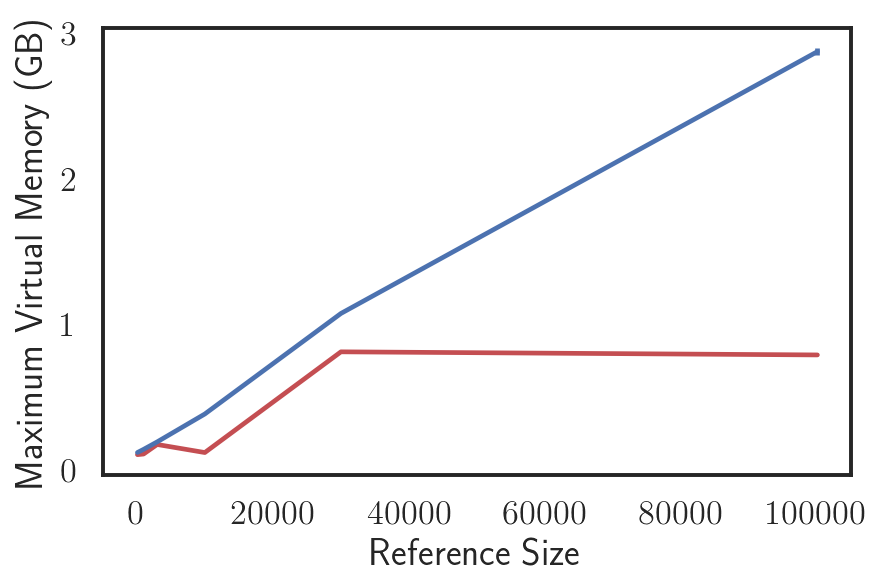

In [28]:
N = [100, 1000, 3000, 10000, 30000, 100000]
#           K =1        2        3        4        5      
mem_usg_eh = [[129008,  129008,  129008,  129008,  129008], # N = 100\ 
              [150588,  150588,  150588,  150588,  150588], # N = 1000\
              [201904,  201904,  201904,  201904,  201904], # N = 3000\
              [393016,  393016,  393016,  393016,  393016], # N = 10000\
              [1082024, 1082024, 1082024, 1082024, 1082024], # N = 30000\
              [2859336, 2859336, 2859336, 2892104, 2911916]] # N = 100000
avg_mem_eh = list(np.mean(mem_usg_eh, axis = 1) / 1000000)
std_mem_eh = list(np.std(mem_usg_eh, axis = 1) / 1000000)
mem_usg_gn = [[114320,  114320,  114320,  114320,  114320], # N = 100\ 
              [118696,  118696,  118696,  118696,  118696], # N = 1000\
              [185508,  185508,  178112,  185508,  185508], # N = 3000\
              [128792,  128792,  128792,  128792,  128792], # N = 10000\
              [819044,  819044,  819044,  819044,  819044], # N = 30000\
              [797744,  797744,  797744,  797744,  797744]] # N = 100000
avg_mem_gn = list(np.mean(mem_usg_gn, axis = 1) / 1000000)
std_mem_gn = list(np.std(mem_usg_gn, axis = 1) / 1000000)

fig = plt.figure(num=3,figsize=(6,4), dpi = 150)
ax = fig.add_subplot(1,1,1)
ax.errorbar(N, avg_mem_gn, yerr = std_mem_gn, color = 'r')
ax.errorbar(N, avg_mem_eh, yerr = std_mem_eh, color = 'b')
ax.set_ylabel('Maximum Virtual Memory (GB)'); ax.set_xlabel('Reference Size')
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.tight_layout()
plt.savefig('Supp4_Virtual_memory.pdf') 
